# Random Forest

## Libraries

In [1]:
#pip install music21
#!pip install imblearn

In [2]:
import numpy as np
import matplotlib.pyplot as plt   
%matplotlib inline
from music21 import *
from IPython.display import Audio
from intervaltree import Interval,IntervalTree
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
import sklearn.model_selection as model_selection

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from collections import Counter
from imblearn.over_sampling import SMOTE
#from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


mn_data = np.load('musicnet.npz','rb',allow_pickle=True)

## Import data

In [3]:
# Import data

metadata = pd.read_csv('cvs_data/musicnet_metadata.csv',index_col=0)

train_wav = pd.read_csv('cvs_data/df_train_wav_consolidated.csv',index_col=0)
test_wav = pd.read_csv('cvs_data/df_test_wav_finc.csv',index_col=0)

In [4]:
#Make a copy of the metadata
meta_data_copy = metadata.copy(deep=True)
meta_data_copy.reset_index(inplace=True)

#Rename column name
meta_data_copy = meta_data_copy.rename(columns = {'id':'filename'})

merged_train_data = pd.merge(train_wav , meta_data_copy , on="filename")
merged_train_data = merged_train_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

merged_test_data = pd.merge(test_wav , meta_data_copy , on="filename")
merged_test_data = merged_test_data.drop(["composer", "composition", "movement","source","transcriber","catalog_name"], axis=1)

In [5]:
#Subset of dataset for only max 2 instruments

subset_list= ['Accompanied Cello','Accompanied Clarinet','Accompanied Violin','Solo Cello', 'Solo Flute', 'Solo Piano', 'Solo Violin', 'Violin and Harpsichord']
subset_merged_train_data = merged_train_data.loc[merged_train_data['ensemble'].isin(subset_list)]
subset_merged_test_data = merged_test_data.loc[merged_test_data['ensemble'].isin(subset_list)]

In [6]:
merged_train_data.shape

(320, 169)

## Ensembles. Count and mapping to numbers

In [7]:
#Get list of unique ensembles
ens_list = merged_train_data['ensemble'].unique()
ens_list

array(['Piano Quintet', 'Solo Piano', 'Piano Trio', 'Viola Quintet',
       'String Quartet', 'Clarinet Quintet',
       'Pairs Clarinet-Horn-Bassoon', 'Wind Quintet', 'Accompanied Cello',
       'Accompanied Clarinet', 'Wind and Strings Octet', 'String Sextet',
       'Piano Quartet', 'Horn Piano Trio', 'Solo Violin', 'Solo Flute',
       'Solo Cello', 'Violin and Harpsichord',
       'Clarinet-Cello-Piano Trio', 'Accompanied Violin', 'Wind Octet'],
      dtype=object)

In [8]:
merged_train_data['ensemble'].value_counts()

Solo Piano                     153
String Quartet                  55
Accompanied Violin              21
Solo Cello                      11
Wind Quintet                     9
Solo Violin                      8
Piano Quartet                    8
Accompanied Cello                7
Piano Trio                       7
String Sextet                    5
Horn Piano Trio                  4
Accompanied Clarinet             4
Pairs Clarinet-Horn-Bassoon      4
Violin and Harpsichord           4
Wind Octet                       4
Piano Quintet                    4
Clarinet Quintet                 3
Solo Flute                       3
Clarinet-Cello-Piano Trio        3
Wind and Strings Octet           2
Viola Quintet                    1
Name: ensemble, dtype: int64

In [9]:
#Concatenate merged_train_data & subset_merged_test_data datasets to count the total instruments
tot = merged_train_data.append(merged_test_data, ignore_index=True)
tot['ensemble'].value_counts()

Solo Piano                     156
String Quartet                  57
Accompanied Violin              22
Solo Cello                      12
Wind Quintet                     9
Solo Violin                      9
Piano Quartet                    8
Piano Trio                       7
Accompanied Cello                7
Pairs Clarinet-Horn-Bassoon      6
String Sextet                    5
Piano Quintet                    4
Violin and Harpsichord           4
Horn Piano Trio                  4
Accompanied Clarinet             4
Wind Octet                       4
Clarinet-Cello-Piano Trio        3
Clarinet Quintet                 3
Solo Flute                       3
Wind and Strings Octet           2
Viola Quintet                    1
Name: ensemble, dtype: int64

In [10]:
#Map list of unique ensemble names to integer
mapping = {item:i for i, item in enumerate(ens_list)}

merged_train_data["ensemble"] = merged_train_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_train_data["ensemble"] = subset_merged_train_data["ensemble"].apply(lambda x: mapping[x])

merged_test_data["ensemble"] = merged_test_data["ensemble"].apply(lambda x: mapping[x])
subset_merged_test_data["ensemble"] = subset_merged_test_data["ensemble"].apply(lambda x: mapping[x])

<ipython-input-10-479b5e9d2693>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_merged_train_data["ensemble"] = subset_merged_train_data["ensemble"].apply(lambda x: mapping[x])
<ipython-input-10-479b5e9d2693>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_merged_test_data["ensemble"] = subset_merged_test_data["ensemble"].apply(lambda x: mapping[x])


In [11]:
merged_train_data

,harmonic,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11,ensemble,seconds
0,1,1727,-379.303101,162.647156,-9.176621,32.432182,5.328461,-3.991111,-3.361601,-5.715063,...,0.175605,0.265776,0.182298,0.224812,0.181814,0.242179,0.158269,0.121263,0,447
1,1,1728,-366.454132,156.238007,-18.998722,21.848427,-2.850184,-6.522263,-3.189569,-6.704351,...,0.312069,0.180508,0.232264,0.274987,0.219109,0.321617,0.162896,0.211763,0,251
2,1,1729,-356.934235,154.882553,-14.612018,32.736038,3.707721,-2.788103,-4.185019,-4.419207,...,0.218462,0.166380,0.216127,0.203571,0.193022,0.384382,0.140584,0.115543,0,444
3,0,1730,-336.124298,151.521805,-6.498520,25.719015,1.903765,-5.264452,-1.326775,-7.777116,...,0.317379,0.170117,0.243895,0.261494,0.219214,0.318214,0.139723,0.232959,0,368
4,1,1733,-336.165588,147.266479,25.078476,2.940196,4.860076,1.597307,-0.116525,0.372643,...,0.188193,0.190122,0.270146,0.111382,0.298910,0.187172,0.059206,0.133015,1,546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1,2632,-396.441010,172.306015,0.622007,-2.508467,7.183948,-9.301075,-11.852103,-8.983286,...,0.344181,0.301497,0.129215,0.365810,0.064607,0.161312,0.088018,0.254689,1,341
316,0,2659,-254.475494,40.942947,-57.287392,-0.766588,-32.497566,-25.447704,-26.127268,-8.698222,...,0.175034,0.058995,0.246774,0.181108,0.149540,0.202733,0.179062,0.426397,14,108
317,1,2633,-359.455872,160.712463,-8.976362,-6.114422,1.894383,-10.785672,-8.798285,-6.835391,...,0.301959,0.182263,0.226968,0.317097,0.090698,0.233522,0.112708,0.310821,1,227
318,1,2677,-373.230133,165.598053,5.217481,-4.764515,4.772682,-8.145834,-11.833659,-8.353687,...,0.388580,0.169461,0.252342,0.093332,0.182789,0.131017,0.173788,0.363395,1,445


In [12]:
X_original_train = merged_train_data.iloc[:,np.r_[:167,168]]
X_original_test = merged_test_data.iloc[:,np.r_[:167,168]]

y_original_train = merged_train_data.iloc[:,167:168]
y_original_test = merged_test_data.iloc[:,167:168]

In [13]:
X_original_train

,harmonic,filename,mfcc_0,mfcc_1,mfcc_2,mfcc_3,mfcc_4,mfcc_5,mfcc_6,mfcc_7,...,contrast_chroma_3,contrast_chroma_4,contrast_chroma_5,contrast_chroma_6,contrast_chroma_7,contrast_chroma_8,contrast_chroma_9,contrast_chroma_10,contrast_chroma_11,seconds
0,1,1727,-379.303101,162.647156,-9.176621,32.432182,5.328461,-3.991111,-3.361601,-5.715063,...,0.125799,0.175605,0.265776,0.182298,0.224812,0.181814,0.242179,0.158269,0.121263,447
1,1,1728,-366.454132,156.238007,-18.998722,21.848427,-2.850184,-6.522263,-3.189569,-6.704351,...,0.142368,0.312069,0.180508,0.232264,0.274987,0.219109,0.321617,0.162896,0.211763,251
2,1,1729,-356.934235,154.882553,-14.612018,32.736038,3.707721,-2.788103,-4.185019,-4.419207,...,0.101538,0.218462,0.166380,0.216127,0.203571,0.193022,0.384382,0.140584,0.115543,444
3,0,1730,-336.124298,151.521805,-6.498520,25.719015,1.903765,-5.264452,-1.326775,-7.777116,...,0.133328,0.317379,0.170117,0.243895,0.261494,0.219214,0.318214,0.139723,0.232959,368
4,1,1733,-336.165588,147.266479,25.078476,2.940196,4.860076,1.597307,-0.116525,0.372643,...,0.176968,0.188193,0.190122,0.270146,0.111382,0.298910,0.187172,0.059206,0.133015,546
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,1,2632,-396.441010,172.306015,0.622007,-2.508467,7.183948,-9.301075,-11.852103,-8.983286,...,0.141298,0.344181,0.301497,0.129215,0.365810,0.064607,0.161312,0.088018,0.254689,341
316,0,2659,-254.475494,40.942947,-57.287392,-0.766588,-32.497566,-25.447704,-26.127268,-8.698222,...,0.096520,0.175034,0.058995,0.246774,0.181108,0.149540,0.202733,0.179062,0.426397,108
317,1,2633,-359.455872,160.712463,-8.976362,-6.114422,1.894383,-10.785672,-8.798285,-6.835391,...,0.157086,0.301959,0.182263,0.226968,0.317097,0.090698,0.233522,0.112708,0.310821,227
318,1,2677,-373.230133,165.598053,5.217481,-4.764515,4.772682,-8.145834,-11.833659,-8.353687,...,0.305187,0.388580,0.169461,0.252342,0.093332,0.182789,0.131017,0.173788,0.363395,445


In [14]:
X_original_train.shape

(320, 168)

In [15]:
X_original_test.shape

(10, 168)

In [16]:
#Concatenate the training and test data
x_frames = [X_original_train, X_original_test]
X = pd.concat(x_frames, ignore_index=True)

y_frames = [y_original_train, y_original_test]
y = pd.concat(y_frames, ignore_index=True)

In [17]:
X.shape

(330, 168)

In [18]:
y['ensemble'].value_counts()

1     156
4      57
19     22
16     12
14      9
7       9
12      8
8       7
2       7
6       6
11      5
20      4
0       4
9       4
13      4
17      4
5       3
15      3
18      3
10      2
3       1
Name: ensemble, dtype: int64

## Splitting sample: 80% development and 20% test

In [19]:
#Got an error in splitting the sample saying: ValueError: The least populated class in y has only 1 member, 
# which is too few. The minimum number of groups for any class cannot be less than 2.
#Hence, I proceeded to remove these cases

index_violaquintet = y[ y['ensemble'] == 3 ].index
y.drop(index_violaquintet , inplace=True)
X.drop(index_violaquintet , inplace=True)

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, train_size=0.80, test_size=0.20, stratify=y, random_state=101)

In [20]:
print(X_train.shape, X_test.shape , y_train.shape, y_test.shape)

(263, 168) (66, 168) (263, 1) (66, 1)


### 1: Sample as it is: No balancing, no hyperparameter tuning

In [21]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)

print('Accuracy score: ', accuracy_score(np.array(y_test), rf_predictions))
print('F1 Score: ', f1_score(rf_predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, rf_predictions))


<ipython-input-21-900febee4900>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_train, y_train)


Accuracy score:  0.8333333333333334
F1 Score:  0.8885595081247255
Classification report: 
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.82      1.00      0.90        31
           2       1.00      1.00      1.00         1
           4       0.77      0.91      0.83        11
           5       0.00      0.00      0.00         1
           6       1.00      1.00      1.00         1
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
           9       0.00      0.00      0.00         1
          11       1.00      1.00      1.00         1
          12       0.00      0.00      0.00         2
          13       1.00      1.00      1.00         1
          14       1.00      1.00      1.00         2
          15       1.00      1.00      1.00         1
          16       1.00      1.00      1.00         2
          17       1.00      1.00      1.00 

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [22]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

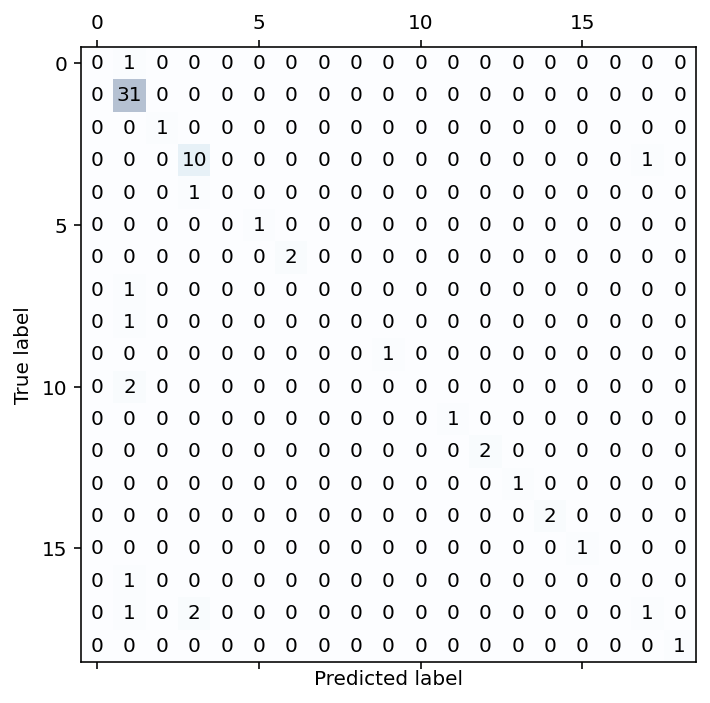

In [23]:
#Run Confusion matrix and plot for rbf kernel SVM
conf_matrix = confusion_matrix(y_test, rf_predictions) 
confusion_matrix_plot(conf_matrix)

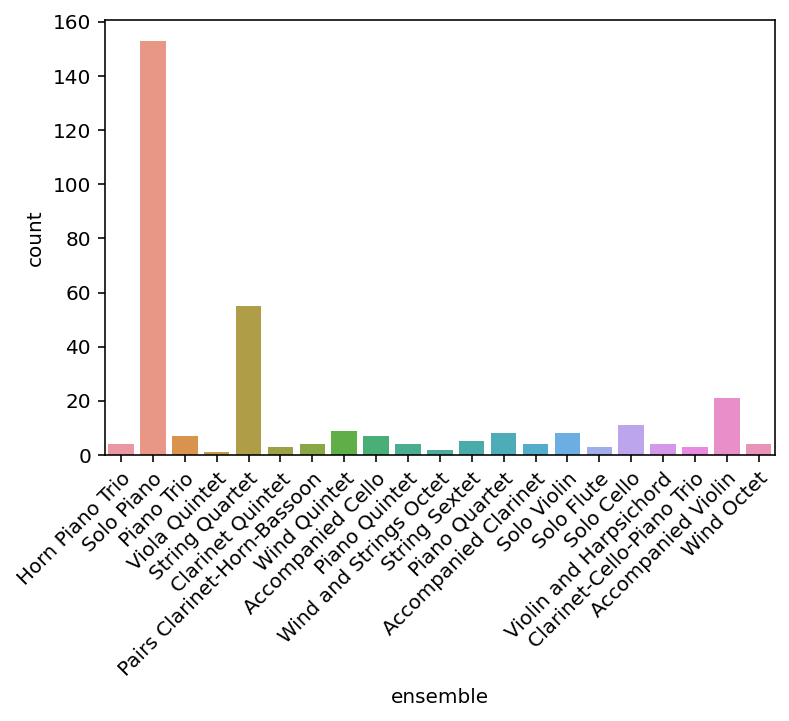

In [24]:
# Visualize the target variable
g = sns.countplot(merged_train_data['ensemble'])
g.set_xticklabels(['Horn Piano Trio',
'Solo Piano',
'Piano Trio',
'Viola Quintet',
'String Quartet',
'Clarinet Quintet',
'Pairs Clarinet-Horn-Bassoon',
'Wind Quintet',
'Accompanied Cello',
'Piano Quintet',
'Wind and Strings Octet',
'String Sextet',
'Piano Quartet',
'Accompanied Clarinet',
'Solo Violin',
'Solo Flute',
'Solo Cello',
'Violin and Harpsichord',
'Clarinet-Cello-Piano Trio',
'Accompanied Violin',
'Wind Octet'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

### 2: Sample with SMOTE, no hyperparameter tuning

In [25]:
#Drop any ensemble types with counts below 6. This because Expected n_neighbors <= n_samples,  
#but n_samples = 3, n_neighbors = 6
counts = y_train['ensemble'].value_counts()
X_train = X_train[~y_train['ensemble'].isin(counts[counts < 6].index)]
y_train = y_train[~y_train['ensemble'].isin(counts[counts < 6].index)]

print(X_train.shape, y_train.shape)

(231, 168) (231, 1)


In [26]:
#Synthetic Minority Oversampling Technique (SMOTE): This technique generates synthetic data for the minority class.

#SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class 
#and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point 
#and its neighbors.


# Fit and apply the transform
X_SMOTE, y_SMOTE = SMOTE().fit_resample(X_train, y_train)

print('Original dataset shape', Counter(y_train.values.ravel()))
print('Resample dataset shape', Counter(y_SMOTE.values.ravel()))

Original dataset shape Counter({1: 125, 4: 46, 19: 18, 16: 10, 14: 7, 7: 7, 12: 6, 8: 6, 2: 6})
Resample dataset shape Counter({19: 125, 1: 125, 12: 125, 14: 125, 16: 125, 4: 125, 7: 125, 8: 125, 2: 125})


In [27]:
y_SMOTE

,ensemble
0,19
1,1
2,1
3,1
4,12
...,...
1120,19
1121,19
1122,19
1123,19


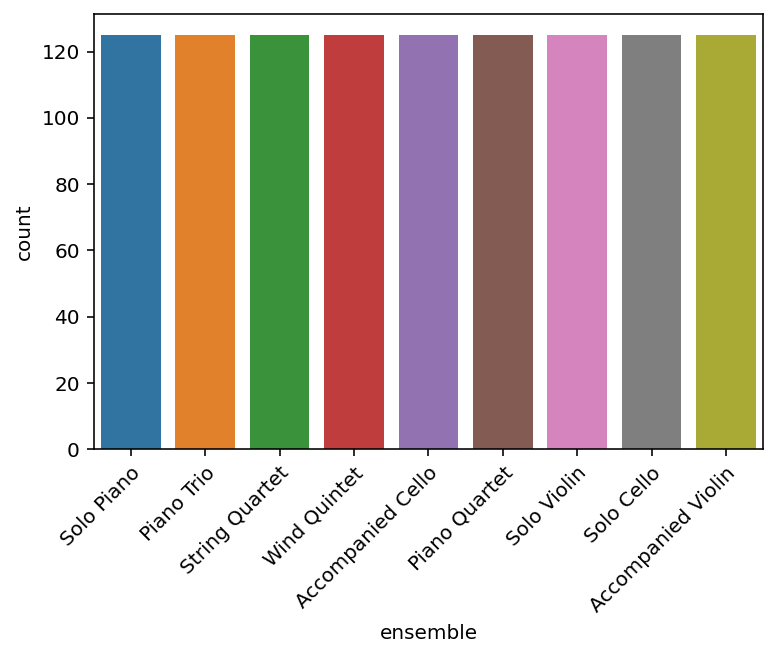

In [28]:
# Visualize the target variable
g = sns.countplot(y_SMOTE['ensemble'])
g.set_xticklabels([
'Solo Piano', 
'Piano Trio',
'String Quartet',
'Wind Quintet',
'Accompanied Cello',
'Piano Quartet',
'Solo Violin',
'Solo Cello',
'Accompanied Violin'],rotation_mode='anchor',rotation=45, ha='right')
plt.show()

In [29]:
y_SMOTE['ensemble'].value_counts()

19    125
16    125
14    125
12    125
8     125
7     125
4     125
2     125
1     125
Name: ensemble, dtype: int64

In [30]:
y_test['ensemble'].value_counts()

1     31
4     11
19     4
7      2
16     2
14     2
12     2
20     1
2      1
5      1
6      1
11     1
8      1
9      1
13     1
15     1
17     1
18     1
0      1
Name: ensemble, dtype: int64

In [31]:
index_lessthan6count = y_test[ y_test['ensemble'].isin([0,3,5,6,9,10,11,13,15,17,18,20])].index
y_test.drop(index_lessthan6count , inplace=True)
X_test.drop(index_lessthan6count , inplace=True)


C:\Users\nojed\anaconda3\lib\site-packages\pandas\core\frame.py:4160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [32]:
y_test['ensemble'].value_counts()

1     31
4     11
19     4
16     2
14     2
12     2
7      2
8      1
2      1
Name: ensemble, dtype: int64

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=1)
rf_classifier.fit(X_SMOTE, y_SMOTE)
rf_predictions = rf_classifier.predict(X_test)

#Default parameters:
    #n_estimatorsint, default=100
    #max_features{“auto”, “sqrt”, “log2”}, int or float, default=”auto”
    #min_samples_splitint or float, default=2

print('Accuracy score: ', accuracy_score(np.array(y_test), rf_predictions))
print('F1 Score: ', f1_score(rf_predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, rf_predictions))

<ipython-input-39-1a17880d9f8c>:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_classifier.fit(X_SMOTE, y_SMOTE)


Accuracy score:  0.9285714285714286
F1 Score:  0.9391156462585034
Classification report: 
               precision    recall  f1-score   support

           1       0.94      0.97      0.95        31
           2       1.00      1.00      1.00         1
           4       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
          12       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          19       0.67      0.50      0.57         4

    accuracy                           0.93        56
   macro avg       0.81      0.83      0.81        56
weighted avg       0.91      0.93      0.92        56



C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


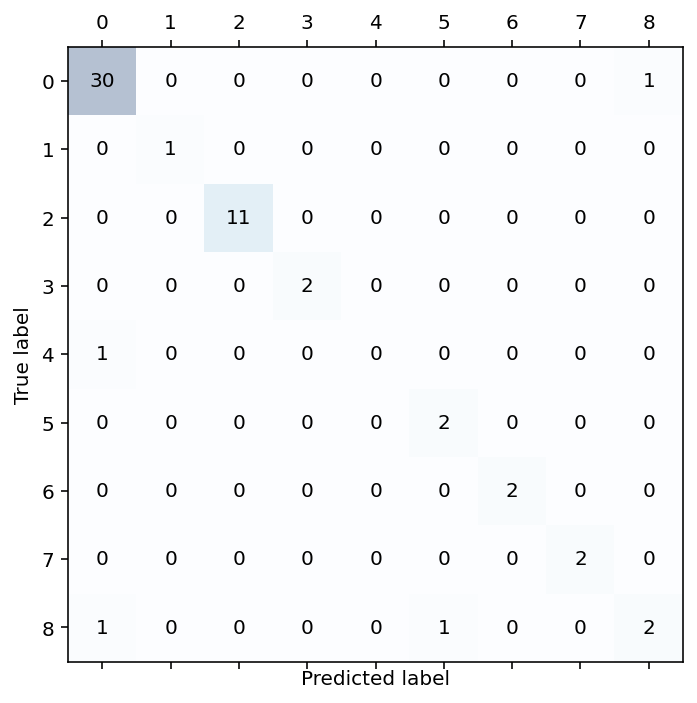

In [40]:
#Run Confusion matrix and plot for rbf kernel SVM
conf_matrix = confusion_matrix(y_test, rf_predictions) 
confusion_matrix_plot(conf_matrix)

### 3: Sample with SMOTE, hyperparameter tuning

There are various hyperparameters that can be controlled in a random forest:

- __N_estimators__: The number of decision trees being built in the forest. Default values in sklearn are 100. N_estimators are mostly correlated to the size of data, to encapsulate the trends in the data, more number of DTs are needed. 
- __Max_features__: Maximum number of features used for a node split process. Types: sqrt, log2. If total features are n_features then: sqrt(n_features) or log2(n_features) can be selected as max features for node splitting.
- __Min_samples_split__: This parameter decides the minimum number of samples required to split an internal node. Default value =2. The problem with such a small value is that the condition is checked on the terminal node. If the data points in the node exceed the value 2, then further splitting takes place. Whereas if a more lenient value like 6 is set, then the splitting will stop early and the decision tree wont overfit on the data.


In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

model_params = {
    'n_estimators': [50, 150, 250],
    'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
    'min_samples_split': [2, 4, 6]
}

# Create random forest classifier model
rf_classifier = RandomForestClassifier(random_state=1)

# set up grid search meta-estimator
clf = GridSearchCV(rf_classifier, model_params, cv=5)

# train the grid search meta-estimator to find the best model
rf_classifier_hypp=clf.fit(X_SMOTE, y_SMOTE)

rf_predictions = rf_classifier_hypp.predict(X_test)



C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:598: DataConversionWarning: A column-vector y wa

AttributeError: 'numpy.ndarray' object has no attribute 'best_estimator_'

In [46]:
print(clf.best_params_)

{'max_features': 0.25, 'min_samples_split': 2, 'n_estimators': 150}


In [44]:
print('Accuracy score: ', accuracy_score(np.array(y_test), rf_predictions))
print('F1 Score: ', f1_score(rf_predictions, np.array(y_test), average='weighted'))
print('Classification report: \n', classification_report(y_test, rf_predictions))

Accuracy score:  0.8928571428571429
F1 Score:  0.9193290631469979
Classification report: 
               precision    recall  f1-score   support

           1       0.91      0.97      0.94        31
           2       0.00      0.00      0.00         1
           4       0.92      1.00      0.96        11
           7       1.00      1.00      1.00         2
           8       0.00      0.00      0.00         1
          12       0.67      1.00      0.80         2
          14       1.00      1.00      1.00         2
          16       1.00      1.00      1.00         2
          19       0.50      0.25      0.33         4

    accuracy                           0.89        56
   macro avg       0.67      0.69      0.67        56
weighted avg       0.85      0.89      0.87        56



C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\nojed\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
